# Deep SVDD

In [1]:
from src.skeleton import BaseModel

### 실험 데이터셋 로드 (MNIST) : A3과 동일
- 정상 데이터 : digit 0
- 비정상 데이터 : 그 외 digit

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch

In [3]:
mnist_train_dataset = MNIST('./datasets', download=True, train=True, transform=transforms.ToTensor())
mnist_test_dataset = MNIST('./datasets', download=True, train=False, transform=transforms.ToTensor())
print(len(mnist_train_dataset), len(mnist_test_dataset))

60000 10000


In [4]:
#print(mnist_train_dataset)
#print(mnist_train_dataset.targets.shape)
#print(mnist_train_dataset.data.shape)
positive_set_train = mnist_train_dataset.data[mnist_train_dataset.targets==0]
positive_set_test = mnist_test_dataset.data[mnist_test_dataset.targets==0]
negative_set_test = mnist_test_dataset.data[mnist_test_dataset.targets!=0][:positive_set_test.shape[0]]
print(positive_set_train.shape, positive_set_test.shape,negative_set_test.shape)

torch.Size([5923, 28, 28]) torch.Size([980, 28, 28]) torch.Size([980, 28, 28])


In [5]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
class MNIST_Anomaly(Dataset):
    def __init__(self, dataset, y):
        self.dataset = dataset
        self.y = y
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        X = self.dataset[index]
        y = self.y[index]
        return X,y,True
    
dataset_train = MNIST_Anomaly(positive_set_train, [torch.tensor(0.0)]*len(positive_set_train))
dataset_p_test = MNIST_Anomaly(positive_set_test, [torch.tensor(0.0)]*len(positive_set_test))
dataset_n_test = MNIST_Anomaly(negative_set_test, mnist_test_dataset.targets[mnist_test_dataset.targets!=0])
dataset_test = ConcatDataset([dataset_p_test, dataset_n_test])
print(len(dataset_train), len(dataset_p_test), len(dataset_n_test), len(dataset_test))

5923 980 980 1960


#### 배치 사이즈 (BATCH), 에폭 수 (EPOCH), learning rate (LR)정의
#### !!! lambda 정의

In [6]:
BATCH = 256
EPOCH = 100
LR = 1e-3
LAMBDA = 1e-2

train, test DataLoader 생성 (train DataLoader만 shuffle)

In [7]:
train_loader = DataLoader(dataset_train, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH)

## !!! Deep SVDD 모델 생성
- ```__init__()``` method에서 모델의 layer 정의
    - !!! input으로 train_loader를 받아, **c**값 도출 (```init_c``` 함수 사용)
- ```forward()``` method에서 모델의 forward pass 정의
    - !!! output 형태 : (batch, **latent dimension**)
- !!! ```criterion()``` method에서 모델의 loss 함수 정의

In [8]:
import torch.nn as nn

HDIM = 64

def init_c(model, train_loader, eps=0.1):
    n = 0
    c = torch.zeros(HDIM).to(device='cuda')
    
    model.cuda()
    model.eval()
    
    for batch, label, mask in train_loader:
        batch=batch.cuda().to(dtype=torch.float)
        label=label.cuda()
        if label.dtype == torch.int32:
            label = label.to(dtype=torch.long)
        elif label.dtype == torch.double:
            label = label.to(dtype=torch.float)
        mask=mask.cuda().to(dtype=torch.bool)
        
        batch = model.preprocess(batch, label, mask)
        with torch.no_grad():
            pred = model(batch, label, mask)
        n += pred.shape[0]
        c += torch.sum(pred, dim=0)
    c /= n
    
    c[(abs(c) < eps) & (c<0)] = -eps
    c[(abs(c) < eps) & (c>0)] = eps
    
    return c.unsqueeze(0)


class MyModel(BaseModel):
    def __init__(self, in_dim, c=None, train_loader=None, shift=0.0, scale=1.0, model_name='my_model'):
        super().__init__(model_name=model_name)
        self.enc1 = nn.Linear(in_dim, 256)
        self.enc2 = nn.Linear(256,128)
        self.enc3 = nn.Linear(128,HDIM)
        self.relu = nn.ReLU()
        self.shift = shift.to(device='cuda')
        self.scale = scale.to(device='cuda')
        if c is None:
            self.c = init_c(self, train_loader)
        else:
            self.c = c
        self.c = self.c.to(device='cuda')
        
    def forward(self, batch, label=None, mask=None):
        x = self.enc1(batch)
        x = self.relu(x)
        x = self.enc2(x)
        x = self.relu(x)
        x = self.enc3(x)
        return x
    
    def preprocess(self, batch, label=None, mask=None):
        batch = (batch-self.shift) / self.scale
        return batch.view(batch.size(0),-1)
    
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        #print(pred.shape, self.c.shape)
        loss = nn.MSELoss()(pred, self.c.repeat(pred.shape[0],1))
        return loss


모델 생성 및 CUDA로 이동
- !!! **train_loader 전달**

In [9]:
model = MyModel(28*28, shift=positive_set_train.min(), scale=(positive_set_train.max()-positive_set_train.min()+1e-10), train_loader=train_loader)
model.cuda()

MyModel(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
)

optimizer 생성
- !!! **Weight Decay 설정**

In [10]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), LR, weight_decay=LAMBDA)

#### ```train_model()``` method를 통해 모델 학습

In [11]:
model.train_model(train_loader, test_loader, EPOCH, optimizer, report_intv=10)

(0.07s) [Epoch 1]
	Train Loss : 0.0014202	Train Score : 0
	Eval Loss : 0.00095347	Eval Score : 0
(0.06s) [Epoch 11]
	Train Loss : 0.00032104	Train Score : 0
	Eval Loss : 0.00064182	Eval Score : 0
(0.06s) [Epoch 21]
	Train Loss : 0.00032062	Train Score : 0
	Eval Loss : 0.0006486	Eval Score : 0
(0.06s) [Epoch 31]
	Train Loss : 0.00032018	Train Score : 0
	Eval Loss : 0.00064114	Eval Score : 0
(0.06s) [Epoch 41]
	Train Loss : 0.00031976	Train Score : 0
	Eval Loss : 0.00063462	Eval Score : 0
(0.06s) [Epoch 51]
	Train Loss : 0.00031794	Train Score : 0
	Eval Loss : 0.00066365	Eval Score : 0
(0.06s) [Epoch 61]
	Train Loss : 0.00032079	Train Score : 0
	Eval Loss : 0.00065631	Eval Score : 0
(0.06s) [Epoch 71]
	Train Loss : 0.00031803	Train Score : 0
	Eval Loss : 0.00065928	Eval Score : 0
(0.06s) [Epoch 81]
	Train Loss : 0.00031906	Train Score : 0
	Eval Loss : 0.00065137	Eval Score : 0
(0.06s) [Epoch 91]
	Train Loss : 0.00031771	Train Score : 0
	Eval Loss : 0.0007243	Eval Score : 0


# 결과 분석

In [12]:
def run_inference(model, dataloader):
    model.eval()
    losses = []
    ys = []
    criterion = nn.MSELoss(reduction='none')
    for batch, label, mask in dataloader:
        batch = batch.cuda().to(dtype=torch.float)
        batch = model.preprocess(batch)
        with torch.no_grad():
            pred = model.forward(batch)
        loss = criterion(pred, model.c.repeat(pred.shape[0],1)).view(pred.shape[0],-1).mean(-1)
        losses.append(loss.cpu())
        ys.append(label)
    losses = torch.cat(losses, 0)
    ys = torch.cat(ys, 0)
    return losses, ys

def find_thres(losses, sigma=3):
    mean = losses.mean()
    std = losses.std()
    thres = mean+std*sigma
    return thres.item()


#### 학습 데이터(정상 데이터)에 대해 loss계산

In [13]:
losses_train, _ = run_inference(model, train_loader)

print(losses_train.shape)

torch.Size([5923])


#### 학습 데이터(정상 데이터)의 loss 분포를 바탕으로 이상 수치 threshold 설정

In [14]:
thres = find_thres(losses_train, sigma=2)
print(thres)

0.0007385670905932784


#### Test 데이터에 대해 loss 계산

In [15]:
losses, ys = run_inference(model, test_loader)

losses_p = losses[ys==0]
losses_n = losses[ys!=0]
print(losses_p.shape, losses_n.shape)

torch.Size([980]) torch.Size([980])


#### 결정된 threshold를 바탕으로, Test 데이터에 대한 Confusion matrix (TP/FP/FN/TN) 및 Accuracy, Precision, Recall 계산

In [16]:
TP = len(losses_p[losses_p<thres])
FN = len(losses_p[losses_p>thres])
TN = len(losses_n[losses_n>thres])
FP = len(losses_n[losses_n<thres])
print('TP : %5d,\tFP : %5d'%(TP, FP))
print('FN : %5d,\tTN : %5d'%(FN ,TN))
print('Accuracy : %.2f,\tPrecision : %.2f,\tRecall : %.2f'%((TP+TN)/(TP+TN+FP+FN), (TP)/(TP+FP+1e-10), (TP)/(TP+FN)))

TP :   930,	FP :   317
FN :    50,	TN :   663
Accuracy : 0.81,	Precision : 0.75,	Recall : 0.95


#### Test 데이터의 각 ground-truth label 별 loss 분포 확인

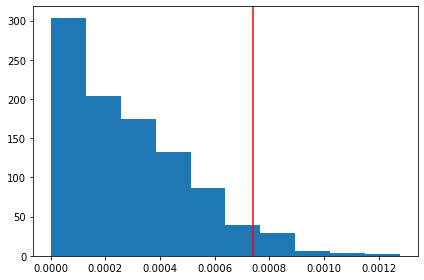

[Normal]
Max : 0.0013	Mean : 0.0003	Min : 0.0000



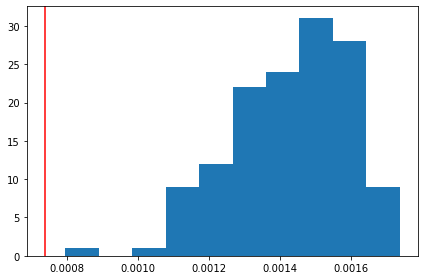

[Anomaly 1]
Max : 0.0017	Mean : 0.0014	Min : 0.0008



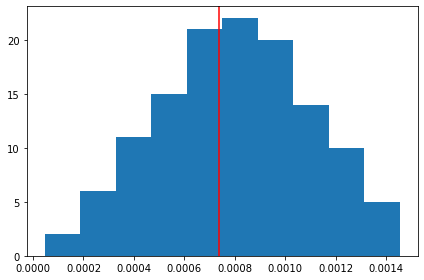

[Anomaly 2]
Max : 0.0015	Mean : 0.0008	Min : 0.0000



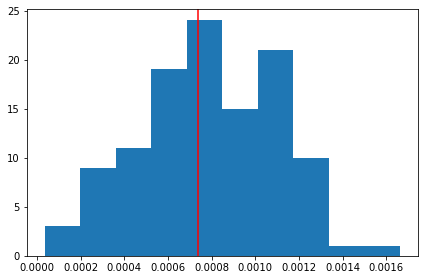

[Anomaly 3]
Max : 0.0017	Mean : 0.0008	Min : 0.0000



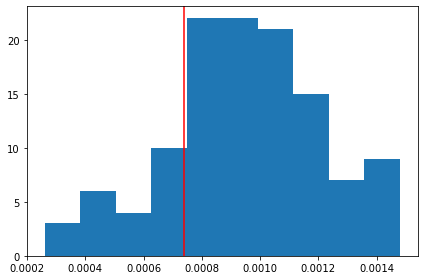

[Anomaly 4]
Max : 0.0015	Mean : 0.0009	Min : 0.0003



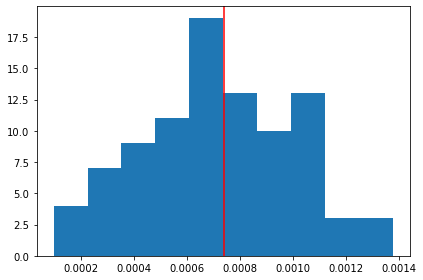

[Anomaly 5]
Max : 0.0014	Mean : 0.0007	Min : 0.0001



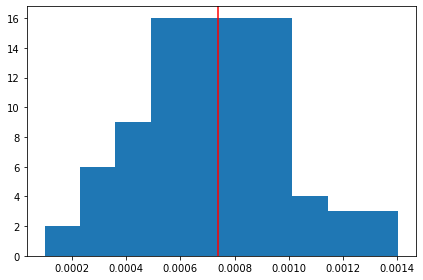

[Anomaly 6]
Max : 0.0014	Mean : 0.0007	Min : 0.0001



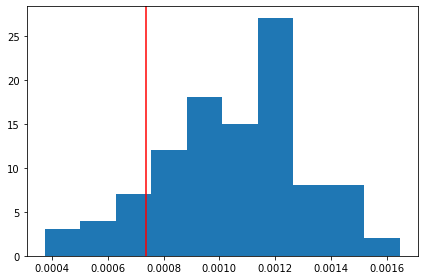

[Anomaly 7]
Max : 0.0016	Mean : 0.0010	Min : 0.0004



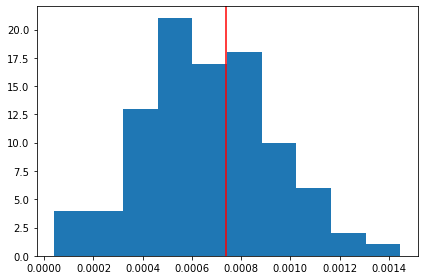

[Anomaly 8]
Max : 0.0014	Mean : 0.0007	Min : 0.0000



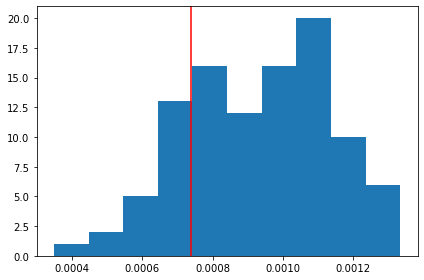

[Anomaly 9]
Max : 0.0013	Mean : 0.0009	Min : 0.0003



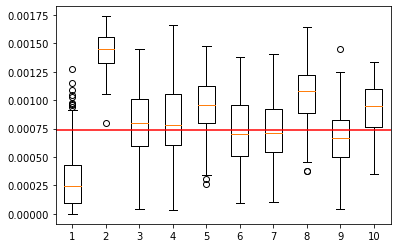

In [17]:
import matplotlib.pyplot as plt
maxes=[]
means=[]
mins=[]
lois = [losses[ys==i] for i in range(10)]
for i in range(10):
    loi = lois[i]
    counts, bins = np.histogram(loi)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.axvline(thres, c='r')
    plt.tight_layout()
    plt.show()
    if i==0:
        print('[Normal]')
    else:
        print('[Anomaly %d]'%i)
    maxes.append(loi.max())
    means.append(loi.mean())
    mins.append(loi.min())
    print('Max : %.4f\tMean : %.4f\tMin : %.4f\n'%(maxes[-1], means[-1], mins[-1]))
    
plt.boxplot(lois)
plt.axhline(thres, c='r')
plt.show()

#### Test 데이터의 각 비정상 상태 label(우)에 대해, 정상 데이터(좌)와의 loss 분포 비교

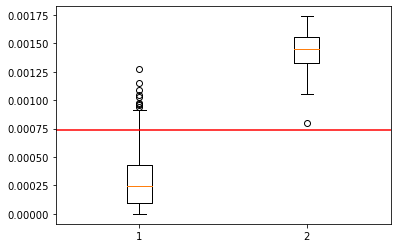

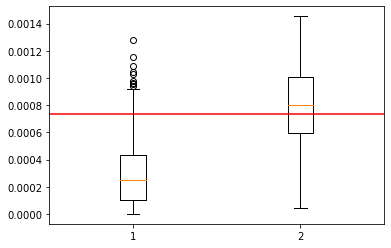

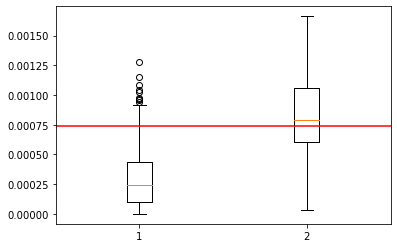

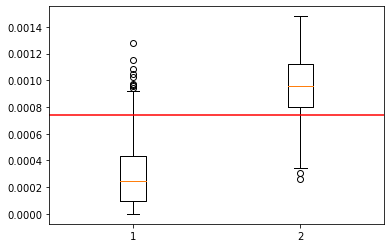

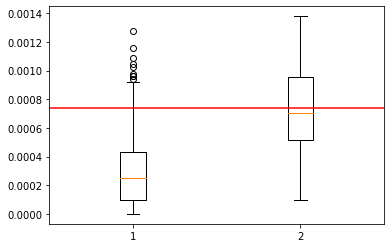

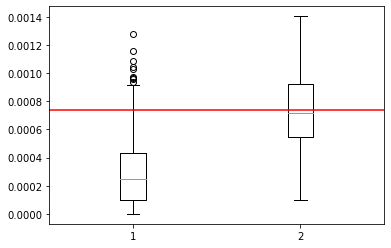

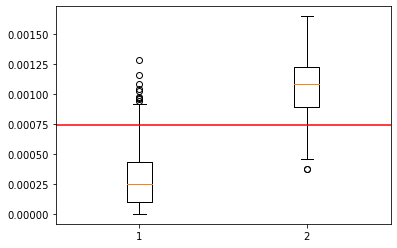

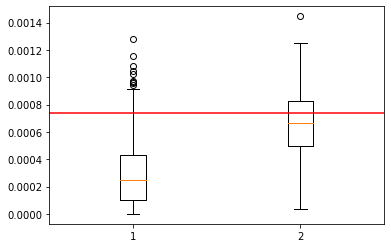

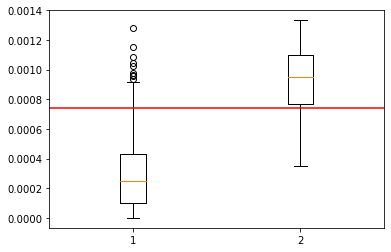

In [18]:
for i in range(9):
    plt.boxplot([lois[0],lois[i+1]])
    plt.axhline(thres, c='r')
    plt.show()

#### ROC 커브 확인

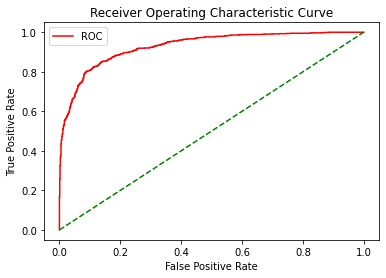

Thres : 1.0017e+00,	FPR : 0.0000,	TPR : 0.0000
Thres : 1.7385e-03,	FPR : 0.0000,	TPR : 0.0010
Thres : 1.3245e-03,	FPR : 0.0000,	TPR : 0.1480
Thres : 1.3235e-03,	FPR : 0.0000,	TPR : 0.1500
Thres : 1.2812e-03,	FPR : 0.0000,	TPR : 0.1694
Thres : 1.2785e-03,	FPR : 0.0010,	TPR : 0.1694
Thres : 1.1566e-03,	FPR : 0.0010,	TPR : 0.2561
Thres : 1.1555e-03,	FPR : 0.0020,	TPR : 0.2561
Thres : 1.0862e-03,	FPR : 0.0020,	TPR : 0.3255
Thres : 1.0855e-03,	FPR : 0.0031,	TPR : 0.3255
Thres : 1.0443e-03,	FPR : 0.0031,	TPR : 0.3663
Thres : 1.0440e-03,	FPR : 0.0041,	TPR : 0.3663
Thres : 1.0293e-03,	FPR : 0.0041,	TPR : 0.3776
Thres : 1.0259e-03,	FPR : 0.0051,	TPR : 0.3776
Thres : 1.0251e-03,	FPR : 0.0051,	TPR : 0.3796
Thres : 1.0173e-03,	FPR : 0.0051,	TPR : 0.3878
Thres : 1.0170e-03,	FPR : 0.0051,	TPR : 0.3898
Thres : 9.7603e-04,	FPR : 0.0051,	TPR : 0.4347
Thres : 9.7528e-04,	FPR : 0.0061,	TPR : 0.4347
Thres : 9.6494e-04,	FPR : 0.0061,	TPR : 0.4531
Thres : 9.6260e-04,	FPR : 0.0071,	TPR : 0.4531
Thres : 9.592

In [19]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve([0]*losses[ys==0].shape[0]+[1]*losses[ys!=0].shape[0], losses.flatten())
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr)
for i in range(len(fpr)):
    print("Thres : %.4e,\tFPR : %.4f,\tTPR : %.4f"%(thresholds[i],fpr[i],tpr[i]))
#print(fpr,tpr,thres)

#### 임의의 THRESHOLD에 대한 결과 지표 확인

In [20]:
THRESHOLD = 6.2215e-04
TP = len(losses_p[losses_p<THRESHOLD])
FN = len(losses_p[losses_p>THRESHOLD])
TN = len(losses_n[losses_n>THRESHOLD])
FP = len(losses_n[losses_n<THRESHOLD])
print('TP : %5d,\tFP : %5d'%(TP, FP))
print('FN : %5d,\tTN : %5d'%(FN ,TN))
print('Accuracy : %.2f,\tPrecision : %.2f,\tRecall : %.2f'%((TP+TN)/(TP+TN+FP+FN), (TP)/(TP+FP), (TP)/(TP+FN)))

TP :   896,	FP :   201
FN :    84,	TN :   779
Accuracy : 0.85,	Precision : 0.82,	Recall : 0.91
